## Описание проекта
Вы — специалист по Data Sciense в каршеринговой компании.<br>
Вам поступил заказ: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения.<br>
Под риском понимается вероятность ДТП с любым повреждением транспортного средства.<br>
Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска.<br>
Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.<br>
Идея создания такой системы находится в стадии предварительного обсуждения и проработки.<br>
Чёткого алгоритма работы и подобных решений на рынке ещё не существует.<br>
Текущая задача — понять, возможно ли предсказывать ДТП, опираясь на исторические данные одного из регионов.

In [1]:
!pip install phik

## Подключитесь к базе. Загрузите таблицы sql

In [2]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install ydata_profiling

In [4]:
!pip install optuna

In [198]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import phik
from phik.report import plot_correlation_matrix
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from ydata_profiling import ProfileReport
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
import optuna
from matplotlib import pyplot

In [6]:
SEED = 12345

In [7]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 
 

In [8]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

## Проведите первичное исследование таблиц

In [9]:
engine = create_engine(connection_string) 


In [10]:
query = '''
select *
from case_ids i
limit 100000
'''

In [11]:
case = pd.read_sql_query(query, con = engine) 
case

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
...,...,...
99995,4191845,2021
99996,4191846,2021
99997,4191847,2021
99998,4191848,2021


Очень странная таблица под названием case_ids. <br>
Не очень ясно зачем она вообще нужна?!

Указан столбец другой (db_year), по факту значение 2021 напротив каждого элемента столбца case_id

In [12]:
query = '''
select *
from parties p 
join vehicles v on v.case_id = p.case_id 
join collisions c on p.case_id = c.case_id
limit 100000

'''

In [13]:
pd.set_option('display.max_columns', None)

In [14]:
df = pd.read_sql_query(query, con = engine) 
df

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,12300,4037555,1,road signs,1,71.0,had not been drinking,None,0.0,6581,4037555,1,hatchback,auto,11.0,4037555,3801,san francisco,0.0,None,NaN,clear,None,scratch,2,vehicle code violation,pedestrian violation,other,other object,dry,normal,daylight,functioning,2009-02-05,15:49:00
1,3332,4018996,1,building,1,58.0,impairment unknown,G,0.0,1987,4018996,1,minivan,manual,9.0,4018996,3024,orange,0.0,None,1.0,clear,None,middle damage,2,vehicle code violation,traffic signals and signs,broadside,bicycle,dry,normal,daylight,functioning,2009-01-17,12:49:00
2,4434,4027566,2,road bumper,1,NaN,had not been drinking,None,0.0,2558,4027566,2,sedan,manual,3.0,4027566,1942,los angeles,200.0,east,0.0,clear,None,scratch,2,vehicle code violation,other hazardous violation,sideswipe,parked motor vehicle,dry,normal,daylight,none,2009-01-26,13:15:00
3,5510,4033038,2,road signs,0,59.0,had not been drinking,None,NaN,3155,4033038,2,hatchback,auto,9.0,4033038,1929,los angeles,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,pedestrian right of way,other,other object,dry,normal,daylight,functioning,2009-01-18,08:15:00
4,6905,4033778,2,road bumper,0,NaN,not applicable,not applicable,0.0,3806,4033778,1,coupe,auto,4.0,4033778,3040,orange,174.0,north,0.0,clear,None,middle damage,2,vehicle code violation,dui,hit object,parked motor vehicle,dry,normal,dark with street lights,none,2009-01-25,18:55:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1741277,5093124,3,car,0,49.0,had not been drinking,None,0.0,953654,5093124,1,sedan,auto,2.0,5093124,2002,madera,0.0,None,1.0,clear,None,small damage,3,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2011-02-01,16:41:00
99996,1741362,5093187,1,car,1,37.0,"had been drinking, under influence",None,0.0,953693,5093187,1,coupe,manual,5.0,5093187,0790,contra costa,528.0,north,0.0,clear,highway,severe damage,2,vehicle code violation,dui,sideswipe,non-collision,dry,normal,dark with street lights,none,2011-02-05,01:20:00
99997,1741363,5093187,2,car,0,63.0,had not been drinking,None,0.0,953693,5093187,1,coupe,manual,5.0,5093187,0790,contra costa,528.0,north,0.0,clear,highway,severe damage,2,vehicle code violation,dui,sideswipe,non-collision,dry,normal,dark with street lights,none,2011-02-05,01:20:00
99998,1743587,5094325,1,car,0,28.0,had not been drinking,None,0.0,954702,5094325,1,sedan,manual,5.0,5094325,1985,los angeles,520.0,south,0.0,clear,None,small damage,2,unknown,unknown,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2011-02-01,18:36:00


In [15]:
query = '''
select *
from parties p 

limit 100000

'''

In [16]:
part = pd.read_sql_query(query, con = engine) 
part

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
...,...,...,...,...,...,...,...,...,...
99995,825513,4559178,1,car,0,51.0,had not been drinking,None,0.0
99996,825514,4559178,2,car,1,39.0,had not been drinking,None,0.0
99997,825523,4559182,2,road bumper,0,NaN,not applicable,not applicable,NaN
99998,825524,4559182,3,road bumper,0,NaN,not applicable,not applicable,NaN


В таблице parties содержит:
- id машины (человека)
- case_id - Id дтп
- номер участника происшествия (party number)
- party_type - тип участника дтп (автомобиль, строения, отбойники, знаки дорожные)
- at_fault - виновность в дтп.
- insurance_premium сумма страховки (по предварительным данным не ясно что за число и что несет за собой, тысячи ли это или просто доллары)
- party_sobriety - трезвость (алкогольное, наркотическое, лекарственное опьянение)
- party_drug_physical - состояние участника дтп. ( лекарства, усталость, болезненность и т.д.)
- наличие телефона (и/или возможность говорить по громкой связи)


Чего-то супер примечательного тут не вижу, нужно будет смотреть далее на таблицу детальнее. 


In [17]:
query = '''
select *
from collisions c
limit 100000

'''

In [18]:
col = pd.read_sql_query(query, con = engine) 
col

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,4468179,3605,san bernardino,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-10-31,12:18:00
99996,4468182,3607,san bernardino,450.0,west,0.0,clear,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,none,2009-11-06,19:20:00
99997,4468186,3607,san bernardino,1060.0,east,0.0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-11-10,15:35:00
99998,4468192,1953,los angeles,200.0,west,0.0,clear,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-10-06,16:40:00


В таблице collisions собралась информация о зарегистрированном дтп
Представлена информация такая как:
- case_id - id дтп
- country city location - номер географического района
- distance - расстояние от главной дороги
- direction - направление движения
- intersection показывает о том, является ли перекрестком
- weather_1 - погодные условия
- location_type - тип дороги 
- collision_damage - серьезность дтп
- party_count кол-во участников дтп
- primary_collision_factor - основной фактор аварии
- pcf_violation_category - категория нарушения
- type_of_collision - тип аварии
- motor_vehicle_involved_with - информация о дополнительных участниках дтп
- road_surface - состояние дороги на момент аварии (погода)
- road_condition_1 - дорожное состояние (ремонт)
- lighting - освещенность дороги
- control_device - устройство управления
- collision_date - дата аварии
- collision_time - время аварии


Здесь бросается в глаза сразу же, что можно дату аварии категоризировать в сезоны (зима, лето, весна, осень), <br>
а время можно категоризировать в время суток (утро, день, вечер, ночь) <br>
county_city_location скорее всего не понадобится вовсе здесь


In [19]:
col.query('distance > 1000')

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
6,4083092,1942,los angeles,1320.0,south,0.0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
8,4083100,1942,los angeles,2112.0,north,0.0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
22,4083160,3315,riverside,1584.0,north,0.0,clear,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-09,11:35:00
26,4083171,3300,riverside,1584.0,east,0.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,construction,daylight,none,2009-01-19,14:20:00
29,4083190,3305,riverside,1056.0,east,0.0,clear,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with no street lights,none,2009-01-06,03:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99976,4468120,3607,san bernardino,1814.0,east,0.0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,dark with street lights,none,2009-11-06,17:20:00
99985,4468152,1989,los angeles,1056.0,south,0.0,clear,highway,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,none,2009-11-05,17:20:00
99989,4468168,4300,santa clara,2640.0,east,0.0,clear,highway,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-10-25,14:15:00
99993,4468174,3604,san bernardino,2112.0,south,0.0,clear,highway,scratch,2,unknown,unknown,overturned,non-collision,dry,normal,daylight,none,2009-11-06,14:44:00


Не очень понимаю, что несет за собой столбец distance. И в каких величинах представлен он. В милях? В футах? В ярдах? <br>
Понадобится ли столбец с направлением движения?<br>
Также я не совсем понимаю столбец direction (можно связать, конечно, время аварии и направление движения.. Возможно, авария случилась по вине слепящего солнца. Но мне это не кажется полезным)

In [20]:
query = '''
select *
from vehicles v
limit 100000

'''

In [21]:
veh =  pd.read_sql_query(query, con = engine) 
veh

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0
...,...,...,...,...,...,...
99995,1353590,5481590,2,sedan,auto,7.0
99996,1353596,5481593,2,sedan,auto,12.0
99997,1353608,5481601,1,sedan,auto,2.0
99998,1353606,5481598,1,sedan,None,3.0


В таблице vehicles представлена информация об автомобилях участников аварий. 
Столбцы:
- id машины
- case_id ид аварии
- party_number - участник аварии (1,2,..)
- vehicle type - тип машины (класс)
- vehicle_transmission - тип трансмиссии 
- vehicle_age -возраст автомобиля

Здесь единственное, что приходит в голову так это то, что старые автомобили могут чаще в авариях бывать. <br>
И есть еще теория, что при большом кол-ве участников аварии виноваты погода, состояние дороги или что-то такое. <br>
Проверим

##  Проведите статистический анализ факторов ДТП

In [22]:
def sql(request):
    return pd.read_sql_query(request, con = engine)

In [23]:
query = '''


SELECT extract('month' from collision_date)::int AS month,COUNT(case_id) AS count
FROM collisions
where extract ('year' from collision_date) < 2012
GROUP BY month
ORDER BY month;

'''

In [24]:
zep = sql(query)

In [25]:
import calendar

In [26]:
zep['month'] = zep['month'].apply(lambda x: calendar.month_name[x])


In [27]:
month_colors = {
   'January': 'blue',
   'February': 'blue',
   'March': 'orange',
   'April': 'orange',
   'May': 'yellow',
   'June': 'yellow',
   'July': 'yellow',
   'August': 'yellow',
   'September': 'orange',
   'October': 'orange',
   'November': 'blue',
   'December': 'blue'
}

# Создаем цветовую палитру
palette = [month_colors[month] for month in zep['month']]


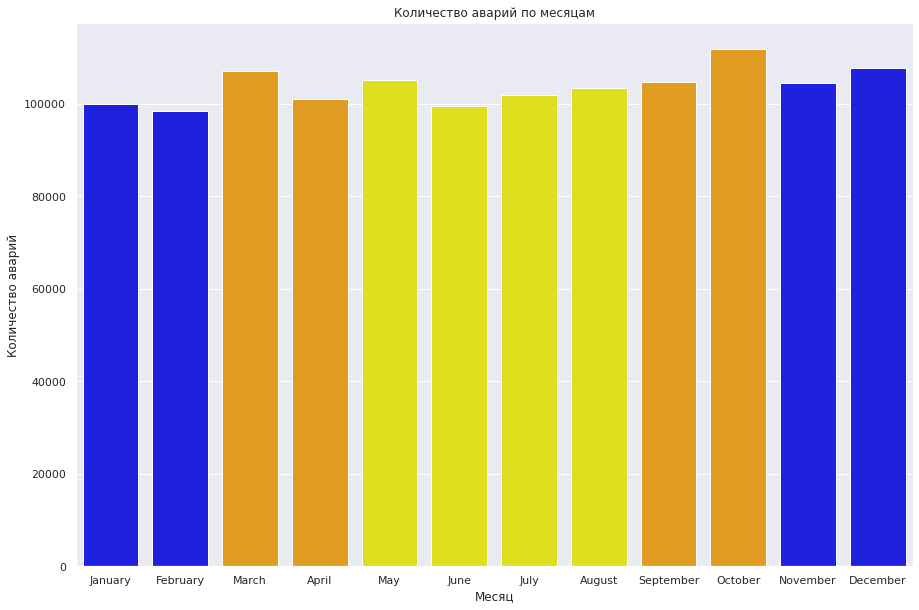

In [28]:
sns.set(rc={"figure.figsize":(15, 10)}) 
sns.set_theme(style="darkgrid")
sns.barplot(x='month', y='count', data=zep, palette= palette)

plt.title('Количество аварий по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество аварий')

plt.show()

Целый год равномерно распределены кол-во аварий. Однако в октябре резкое увеличение <br>
Скорее всего, логично полагать, что лёд и снег - большой риск к возникновению аварии. <br>
Значит, обязательный пункт каршеринговой компании - вовремя поменять резину на своих авто, дабы этот риск еще сильнее не увеличивать. А также следить на кол-вом и качеством шипов на своих авто. <br>


### Задачи для аналитического отдела:
1. Проверить как возраст авто влияет на кол-во аварий, и  какова серьезность повреждений. Например, для каждого типа серьезности повреждения можно вывести средний возраст автомобиля. 
2. Сравнить южные штаты и северные по кол-ву аварий по месяцам. Гипотеза: снег и лёд - виновник аварий. 
3. Проверить степень алкоголя в крови для виновников аварий. Гипотеза: алкоголь - одна из причин аварий. 
4. Проверить наличие освещения в момент ДТП. Гипотеза: недостаток света на дороге влечет аварии. 
5. Общая проверка корреляции. 
6. Осмотреть данные ДТП на перекрестках. Гипотеза: плохорегулирумые перекрестки - причина аварий. 
7. Проверка погодных условий в момент ДТП. Гипотеза: туман, дождь, ветер и снег - одна из причин аварий.
8. Проверить в какое время чаще случаются аварии. Гипотеза: ночное время суток из-за недостатка освещения влечет за собой увеличенное кол-во аварий. 
9. Проверить серьезность аварий при превышении скорости. Гипотеза: ограничение скорости - снизит частоту аварий.

Нужно еще обязательно как-то найти точки влияния на снижение взносов страховой компании (полезное понижение расходов каршеринговой компании, но пока не понимаю с чем связать именно)

### 1. Проверка влияния возраста автомобиля на кол-во аварий и их серьезность.

In [29]:
query = '''
select c.collision_damage, count(c.case_id), avg(v.vehicle_age)
from parties p 
join vehicles v on v.case_id = p.case_id 
join collisions c on p.case_id = c.case_id
where p.at_fault = 1
GROUP BY collision_damage


'''

In [30]:
damage = pd.read_sql_query(query, con = engine)
damage

,collision_damage,count,avg
0,fatal,14273,6.349788
1,middle damage,207313,5.187360
2,scratch,432669,5.531336
3,severe damage,38592,5.441831
4,small damage,264012,4.262023


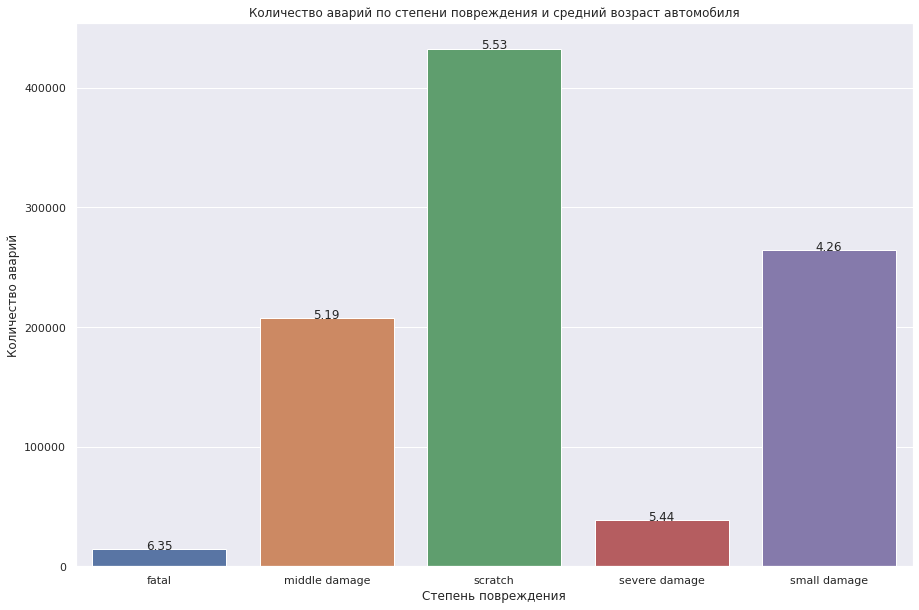

In [31]:
sns.set(rc={"figure.figsize":(15, 10)}) 
sns.set_theme(style="darkgrid")
average_ages = damage['avg'].tolist()

ax = sns.barplot(x='collision_damage', y='count', data=damage)
for p, average_age in zip(ax.patches, average_ages):
   height = p.get_height()
   ax.text(x=p.get_x()+(p.get_width()/2), 
           y=height, 
           s=f'{average_age:.2f}', 
           ha='center')
plt.title('Количество аварий по степени повреждения и средний возраст автомобиля')
plt.xlabel('Степень повреждения')
plt.ylabel('Количество аварий')

plt.show()

Моя догадка подтвердилась, но особо много она не дала. <br>
Да, для фатального повреждения средний возраст автомобиля больше, чем для всех остальных степеней повреждения. <br>
Что еще можно выудить из этого графика? <br>
Царапин больше всего среди ДТП, это и плюс и минус одновременно. <br>
Для оценки водительского риска мы не будем использовать царапины, а это минус данные. <br>
Однако, если не учитывать царапины, то степень повреждения сильно зависит от среднего возраста автомобиля, что заставляет нас задуматься, что для более безопасного передвижения клиентов необходимо обновлять штат автомобилей каршеринга. <br>
По кол-ву все максимально логично и кол-во дтп - чем выше степень повреждения, тем ниже их кол-во. 

### 2 Проверить серьезность аварий при превышении скорости. Гипотеза: ограничение скорости - снизит частоту аварий.

In [32]:
query = '''
select (c.collision_damage), count(c.case_id)
from parties p 
join vehicles v on v.case_id = p.case_id 
join collisions c on p.case_id = c.case_id
where p.at_fault = 1 and
PCF_VIOLATION_CATEGORY = 'speeding'
GROUP BY c.collision_damage


'''

In [33]:
speed = pd.read_sql_query(query, con = engine)
speed

,collision_damage,count
0,fatal,2407
1,middle damage,47373
2,scratch,171979
3,severe damage,7531
4,small damage,108517


In [34]:
query = '''
select (c.collision_damage), count(c.case_id)
from parties p 
join vehicles v on v.case_id = p.case_id 
join collisions c on p.case_id = c.case_id
where p.at_fault = 1 
GROUP BY c.collision_damage

'''

In [35]:
other_with_speed = pd.read_sql_query(query, con = engine)
other_with_speed

,collision_damage,count
0,fatal,14273
1,middle damage,207313
2,scratch,432669
3,severe damage,38592
4,small damage,264012


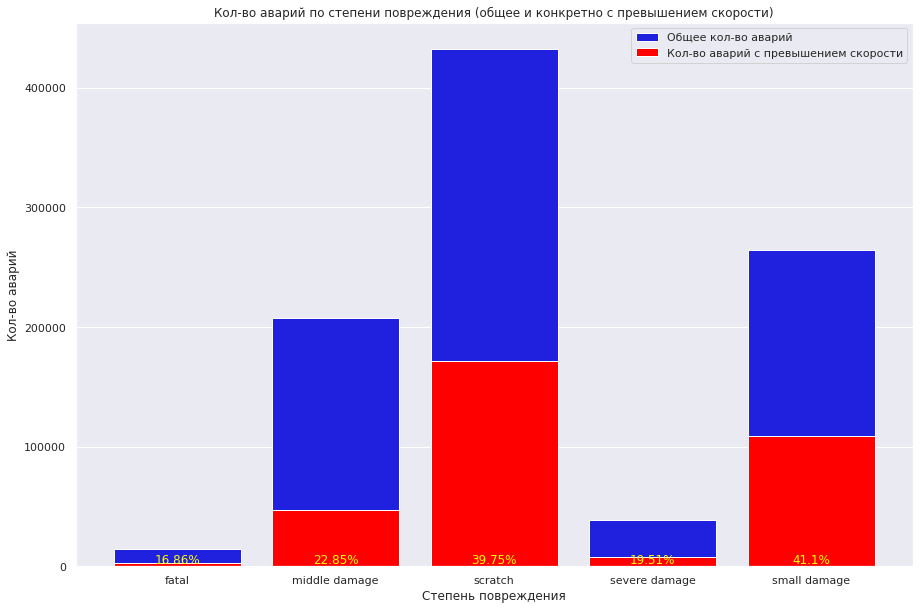

In [36]:
ax = sns.barplot(x='collision_damage', y='count', data=other_with_speed, color='blue', label='Общее кол-во аварий')

# Создание второго графика
plt.bar(speed['collision_damage'], speed['count'], color='red', label= 'Кол-во аварий с превышением скорости')

# Установка заголовков
plt.title('Кол-во аварий по степени повреждения (общее и конкретно с превышением скорости)')
plt.xlabel('Степень повреждения')
plt.ylabel('Кол-во аварий')
speed['percentage'] = speed['count'] / other_with_speed['count'] * 100

# Добавление процентных значений на график
for i, v in enumerate(speed['percentage']):
   ax.text(i, v, str(round(v, 2)) + '%', color='yellow', ha='center', va='bottom')
plt.legend()
plt.show()

Из данного графика видно, что почти 17% фатальных случаев аварий именно из-за превышения скорости. <br>
Если аппаратно блокировать превышение скорости (превышение более чем на 10км/ч разрешенного значения для данной дороги), то это может позволить снизить кол-во летальных случаев ДТП и тем самым снизить расходы на ремонт автомобилей для каршерингового бизнеса. <br>
По остальным типам повреждений видно, что также значительная часть именно из-за превышения скорости. 

## Создайте модель для оценки водительского риска

Нужно подготовить данные на основе первичного предложения заказчика. 
- Выберите тип виновника — только машина (car). 
- Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
- Для моделирования возьмите данные только за 2012 год.
- Подготовка исходной таблицы должна проводиться с помощью sql-запроса.

Задача, которую просит сделать заказчик - в текущий момент невыполнима из-за даже неправильного ТЗ и данные, которые не дают возможности предсказать ДТП. <br>
С данными, которые дал заказчик возможно предсказать лишь вину водителя. <br>
at_fault - предполагает вину водителя, а не факт попадания в дтп или нет. <br>
Если бы у нас были данные, где водители не попадают в аварию - задача была бы реализована (скорее всего). <br>
Далее я буду пытаться следовать заданию, но изначально его уже не выполнить. 

In [37]:
query = '''
select *
from parties p 
join vehicles v on v.case_id = p.case_id 
join collisions c on p.case_id = c.case_id
where c.collision_damage not like 'scratch'
and extract('year' from c.collision_date) = 2012
and p.party_type like 'car'
'''

In [38]:
df = pd.read_sql_query(query, con = engine)

In [39]:
df

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,2405693,5454399,2,car,0,48.0,had not been drinking,None,0.0,1326100,5454399,1,sedan,manual,3.0,5454399,3616,san bernardino,2000.0,north,0.0,clear,highway,small damage,2,vehicle code violation,unsafe lane change,broadside,other motor vehicle,dry,normal,dark with street lights,none,2012-02-01,03:40:00
1,2405692,5454399,1,car,1,21.0,had not been drinking,None,0.0,1326100,5454399,1,sedan,manual,3.0,5454399,3616,san bernardino,2000.0,north,0.0,clear,highway,small damage,2,vehicle code violation,unsafe lane change,broadside,other motor vehicle,dry,normal,dark with street lights,none,2012-02-01,03:40:00
2,2405771,5454433,2,car,0,56.0,had not been drinking,None,0.0,1326124,5454433,2,sedan,manual,3.0,5454433,1964,los angeles,300.0,east,0.0,clear,None,small damage,2,vehicle code violation,dui,sideswipe,other motor vehicle,dry,normal,dark with street lights,none,2012-01-29,02:03:00
3,2405770,5454433,1,car,1,22.0,"had been drinking, under influence",None,0.0,1326124,5454433,2,sedan,manual,3.0,5454433,1964,los angeles,300.0,east,0.0,clear,None,small damage,2,vehicle code violation,dui,sideswipe,other motor vehicle,dry,normal,dark with street lights,none,2012-01-29,02:03:00
4,2405776,5454436,2,car,0,60.0,had not been drinking,None,0.0,1326126,5454436,1,sedan,manual,4.0,5454436,3700,san diego,20.0,north,0.0,clear,ramp,small damage,2,vehicle code violation,unsafe starting or backing,other,other motor vehicle,dry,normal,daylight,functioning,2012-01-27,11:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118406,2749271,5666696,1,car,1,23.0,had not been drinking,None,0.0,1515838,5666696,1,sedan,auto,3.0,5666696,2700,monterey,1320.0,west,0.0,clear,None,small damage,1,vehicle code violation,speeding,hit object,fixed object,dry,normal,daylight,none,2012-06-03,16:02:00
118407,2749294,5666711,1,car,1,23.0,had not been drinking,None,0.0,1515854,5666711,2,sedan,auto,6.0,5666711,1942,los angeles,500.0,east,0.0,clear,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,2012-06-09,15:50:00
118408,2749295,5666711,2,car,0,41.0,had not been drinking,None,0.0,1515854,5666711,2,sedan,auto,6.0,5666711,1942,los angeles,500.0,east,0.0,clear,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,2012-06-09,15:50:00
118409,2749294,5666711,1,car,1,23.0,had not been drinking,None,0.0,1515852,5666711,1,sedan,manual,3.0,5666711,1942,los angeles,500.0,east,0.0,clear,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,2012-06-09,15:50:00


- case_id нам не требуется. <br>
- как и party number.<br>
- party type нам также не нужен, это единственное значение в этом столбце. <br>
- insurance_premium насколько я понимаю, отображает страховку оплаченную водителем. По идее, поведение водителя может отличаться от наличия и стоимости большой страховки.  <br>
- party_sobriety - оставляем, конечно же, важная инфа о состоянии водителя.<br>
- также и party_drug_physical. Тоже отображает состояние водителя. <br>
- cellphone_in_use - оставим, проверим как сильно влияет. <br>
- vehicle_type - тяжело говорить о важности. Но я оставлю, посмотрю. <br>
- vehicle_transmission - точно бесполезна, не вижу логики в этом столбце. <br>
- vehicle_age - важный столбец, мы уже просмотрели ранее, что средний возраст влияет на безопасность. <br>
- county_city_location - для нашей задачи бесполезен. <br>
- county_location - скорее всего также будет бесполезен. Ведь нам нужны детали для снижения риска общего, а не для конкретного типа местности. <br>
- distance - в целом, не очень понимаю этот столбец, я его уберу. <br>
- direction - не вижу смысла в нем. Только связь солнца, времени. (ослепление от солнца), попробую оставить, вдруг модель увидит смысл и качество улучшится<br>
- intersection - думаю, важен. перекрестки особенно опасны, особенно, если плохо регулируются <br>
- weather_1 - точно важный столбец. Погода сильно влияет на безопасность водителя и автомобиля. <br>
- location_type - думаю, не самый важный столбец, но пусть будет. <br>
- collision_damage - думаю, не сильно важен. ибо нам важно снижение риска в целом. Но оставим и проверим далее<br>
- primary_collision_factor - важный столбец, пусть будет. Если водитель забыл, можно его разбудить программно. (снабжать рули антисонным режимом, знаю, такие есть) <br>
- motor_vehicle_involved_with - показывает с кем или чем произошла авария, оставим
- pcf_violation_category - очень важный. Я думаю, каршеринговые компании могут смело вносить в черный список пользователей, которые часто нарушают, дабы защитить их от лишнего риска "убиться". 
- type_of_collision - этот столбец важен, место, куда был удар поможет нам опознать виновника и невиновного водителя. <br>
- road_surface - важно, погода влияет на устойчивость машины на дороге. <br>
- road_condition_1 - также не бесполезен, будет влиять. <br>
- lighting - освещение важный фактор безопасного движения. <br>
- control_device - не сильно понимаю столбец этот. <br>
- collision_date - требует категоризации. <br>
- collision_time - требует категоризации также. 

In [40]:
df['collision_time'] 

0         03:40:00
1         03:40:00
2         02:03:00
3         02:03:00
4         11:30:00
            ...   
118406    16:02:00
118407    15:50:00
118408    15:50:00
118409    15:50:00
118410    15:50:00
Name: collision_time, Length: 118411, dtype: object

In [41]:
df['collision_date'] = pd.to_datetime(df['collision_date'])

In [42]:
df['season'] = np.where((df['collision_date'].dt.month >= 12) | (df['collision_date'].dt.month < 3), 'зима', 
                      np.where((df['collision_date'].dt.month >= 3) & (df['collision_date'].dt.month < 6), 'весна', 
                               np.where((df['collision_date'].dt.month >= 6) & (df['collision_date'].dt.month < 9), 'лето', 'осень')))

In [43]:
df['collision_time'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S')

In [44]:
df['collision_time'].unique()

array(['1900-01-01T03:40:00.000000000', '1900-01-01T02:03:00.000000000',
       '1900-01-01T11:30:00.000000000', ...,
       '1900-01-01T05:12:00.000000000', '1900-01-01T04:27:00.000000000',
       '1900-01-01T04:51:00.000000000'], dtype='datetime64[ns]')

In [45]:
df['time_of_day'] = np.where(
  (df['collision_time'].dt.hour >= 4) & (df['collision_time'].dt.hour < 12), 
  'утро', 
  np.where(
      (df['collision_time'].dt.hour >= 12) & (df['collision_time'].dt.hour < 18), 
      'день', 
      np.where(
          (df['collision_time'].dt.hour >= 18) & (df['collision_time'].dt.hour < 22), 
          'вечер', 
          'ночь'
      )
  )
)

In [46]:
df['time_of_day']

0         ночь
1         ночь
2         ночь
3         ночь
4         утро
          ... 
118406    день
118407    день
118408    день
118409    день
118410    день
Name: time_of_day, Length: 118411, dtype: object

In [47]:
df['season']

0         зима
1         зима
2         зима
3         зима
4         зима
          ... 
118406    лето
118407    лето
118408    лето
118409    лето
118410    лето
Name: season, Length: 118411, dtype: object

In [48]:
df

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,season,time_of_day
0,2405693,5454399,2,car,0,48.0,had not been drinking,None,0.0,1326100,5454399,1,sedan,manual,3.0,5454399,3616,san bernardino,2000.0,north,0.0,clear,highway,small damage,2,vehicle code violation,unsafe lane change,broadside,other motor vehicle,dry,normal,dark with street lights,none,2012-02-01,1900-01-01 03:40:00,зима,ночь
1,2405692,5454399,1,car,1,21.0,had not been drinking,None,0.0,1326100,5454399,1,sedan,manual,3.0,5454399,3616,san bernardino,2000.0,north,0.0,clear,highway,small damage,2,vehicle code violation,unsafe lane change,broadside,other motor vehicle,dry,normal,dark with street lights,none,2012-02-01,1900-01-01 03:40:00,зима,ночь
2,2405771,5454433,2,car,0,56.0,had not been drinking,None,0.0,1326124,5454433,2,sedan,manual,3.0,5454433,1964,los angeles,300.0,east,0.0,clear,None,small damage,2,vehicle code violation,dui,sideswipe,other motor vehicle,dry,normal,dark with street lights,none,2012-01-29,1900-01-01 02:03:00,зима,ночь
3,2405770,5454433,1,car,1,22.0,"had been drinking, under influence",None,0.0,1326124,5454433,2,sedan,manual,3.0,5454433,1964,los angeles,300.0,east,0.0,clear,None,small damage,2,vehicle code violation,dui,sideswipe,other motor vehicle,dry,normal,dark with street lights,none,2012-01-29,1900-01-01 02:03:00,зима,ночь
4,2405776,5454436,2,car,0,60.0,had not been drinking,None,0.0,1326126,5454436,1,sedan,manual,4.0,5454436,3700,san diego,20.0,north,0.0,clear,ramp,small damage,2,vehicle code violation,unsafe starting or backing,other,other motor vehicle,dry,normal,daylight,functioning,2012-01-27,1900-01-01 11:30:00,зима,утро
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118406,2749271,5666696,1,car,1,23.0,had not been drinking,None,0.0,1515838,5666696,1,sedan,auto,3.0,5666696,2700,monterey,1320.0,west,0.0,clear,None,small damage,1,vehicle code violation,speeding,hit object,fixed object,dry,normal,daylight,none,2012-06-03,1900-01-01 16:02:00,лето,день
118407,2749294,5666711,1,car,1,23.0,had not been drinking,None,0.0,1515854,5666711,2,sedan,auto,6.0,5666711,1942,los angeles,500.0,east,0.0,clear,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,2012-06-09,1900-01-01 15:50:00,лето,день
118408,2749295,5666711,2,car,0,41.0,had not been drinking,None,0.0,1515854,5666711,2,sedan,auto,6.0,5666711,1942,los angeles,500.0,east,0.0,clear,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,2012-06-09,1900-01-01 15:50:00,лето,день
118409,2749294,5666711,1,car,1,23.0,had not been drinking,None,0.0,1515852,5666711,1,sedan,manual,3.0,5666711,1942,los angeles,500.0,east,0.0,clear,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,daylight,none,2012-06-09,1900-01-01 15:50:00,лето,день


In [49]:
df_for_model = df[['party_sobriety', 'insurance_premium', 'party_drug_physical', 'cellphone_in_use', 'vehicle_type', 'vehicle_age', 'intersection', 
                'weather_1', 'location_type', 'collision_damage', 'primary_collision_factor', 'pcf_violation_category',
                  'type_of_collision', 'road_surface', 'motor_vehicle_involved_with','road_condition_1', 'lighting', 'season', 'time_of_day', 'at_fault']]

In [50]:
df_for_model

,party_sobriety,insurance_premium,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_age,intersection,weather_1,location_type,collision_damage,primary_collision_factor,pcf_violation_category,type_of_collision,road_surface,motor_vehicle_involved_with,road_condition_1,lighting,season,time_of_day,at_fault
0,had not been drinking,48.0,None,0.0,sedan,3.0,0.0,clear,highway,small damage,vehicle code violation,unsafe lane change,broadside,dry,other motor vehicle,normal,dark with street lights,зима,ночь,0
1,had not been drinking,21.0,None,0.0,sedan,3.0,0.0,clear,highway,small damage,vehicle code violation,unsafe lane change,broadside,dry,other motor vehicle,normal,dark with street lights,зима,ночь,1
2,had not been drinking,56.0,None,0.0,sedan,3.0,0.0,clear,None,small damage,vehicle code violation,dui,sideswipe,dry,other motor vehicle,normal,dark with street lights,зима,ночь,0
3,"had been drinking, under influence",22.0,None,0.0,sedan,3.0,0.0,clear,None,small damage,vehicle code violation,dui,sideswipe,dry,other motor vehicle,normal,dark with street lights,зима,ночь,1
4,had not been drinking,60.0,None,0.0,sedan,4.0,0.0,clear,ramp,small damage,vehicle code violation,unsafe starting or backing,other,dry,other motor vehicle,normal,daylight,зима,утро,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118406,had not been drinking,23.0,None,0.0,sedan,3.0,0.0,clear,None,small damage,vehicle code violation,speeding,hit object,dry,fixed object,normal,daylight,лето,день,1
118407,had not been drinking,23.0,None,0.0,sedan,6.0,0.0,clear,highway,small damage,vehicle code violation,unsafe lane change,sideswipe,dry,other motor vehicle,normal,daylight,лето,день,1
118408,had not been drinking,41.0,None,0.0,sedan,6.0,0.0,clear,highway,small damage,vehicle code violation,unsafe lane change,sideswipe,dry,other motor vehicle,normal,daylight,лето,день,0
118409,had not been drinking,23.0,None,0.0,sedan,3.0,0.0,clear,highway,small damage,vehicle code violation,unsafe lane change,sideswipe,dry,other motor vehicle,normal,daylight,лето,день,1


## EDA

Рассмотрим каждый столбец более вниманительно. Поработаем с аномалиями, проверим на дупликаты.

In [51]:
profile = ProfileReport(df_for_model, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Вкратце оценивая датасет, то здесь есть и пропущенные значения в столбцах (некоторые и вовсе становятся бесполезными из-за огромного кол-ва пропусков), есть дупликаты, которые необходимо удалить. Есть высоко коррелирующие с другими столбцами. Также я увидел аномалии с возрастом авто, а также дисбалансы по многим столбцам.<br> Более конкретно и детально сейчас всё исправим и подчистим. 

Для каждого столбца я буду смотреть значения, строить график, если понадобится и смотреть на пропуски

In [52]:
df_for_model.columns

Index(['party_sobriety', 'insurance_premium', 'party_drug_physical',
       'cellphone_in_use', 'vehicle_type', 'vehicle_age', 'intersection',
       'weather_1', 'location_type', 'collision_damage',
       'primary_collision_factor', 'pcf_violation_category',
       'type_of_collision', 'road_surface', 'motor_vehicle_involved_with',
       'road_condition_1', 'lighting', 'season', 'time_of_day', 'at_fault'],
      dtype='object')

In [53]:
def values_and_missing(column):
    print(df_for_model[column].value_counts())
    print('missing_values: ',df_for_model[column].isna().sum())

### party sobriety

In [54]:
values_and_missing('party_sobriety')

had not been drinking                     101972
had been drinking, under influence          6501
impairment unknown                          6097
had been drinking, not under influence       976
not applicable                               580
had been drinking, impairment unknown        556
Name: party_sobriety, dtype: int64
missing_values:  1729


missing значения поменяю на категорию impairment unknown


In [55]:
pd.options.mode.chained_assignment = None 

In [56]:
df_for_model['party_sobriety'] = df_for_model['party_sobriety'].fillna('impairment unknown')

In [57]:
values_and_missing('party_sobriety')

had not been drinking                     101972
impairment unknown                          7826
had been drinking, under influence          6501
had been drinking, not under influence       976
not applicable                               580
had been drinking, impairment unknown        556
Name: party_sobriety, dtype: int64
missing_values:  0


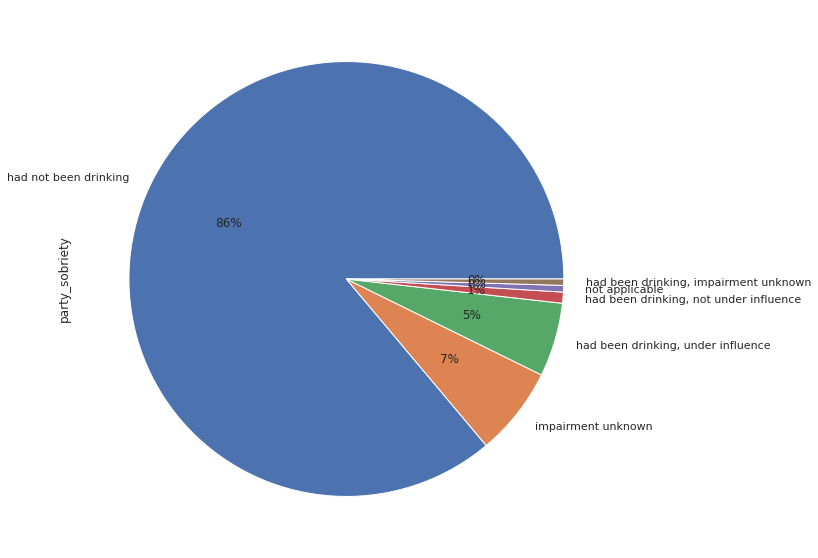

In [58]:
df_for_model['party_sobriety'].value_counts().plot.pie(autopct='%1.0f%%')
plt.show()

Дисбаланс большой, но он тут логичен, а данные эти нам нужны

### insurance_premium

In [59]:
values_and_missing('insurance_premium')

19.0     3867
20.0     3865
21.0     3844
22.0     3563
23.0     3398
         ... 
99.0        3
100.0       2
105.0       1
2.0         1
102.0       1
Name: insurance_premium, Length: 102, dtype: int64
missing_values:  5122


In [60]:
def plots(column):
    sns.histplot(df_for_model[column])
    plt.show()
    sns.violinplot(df_for_model[column])
    plt.show()

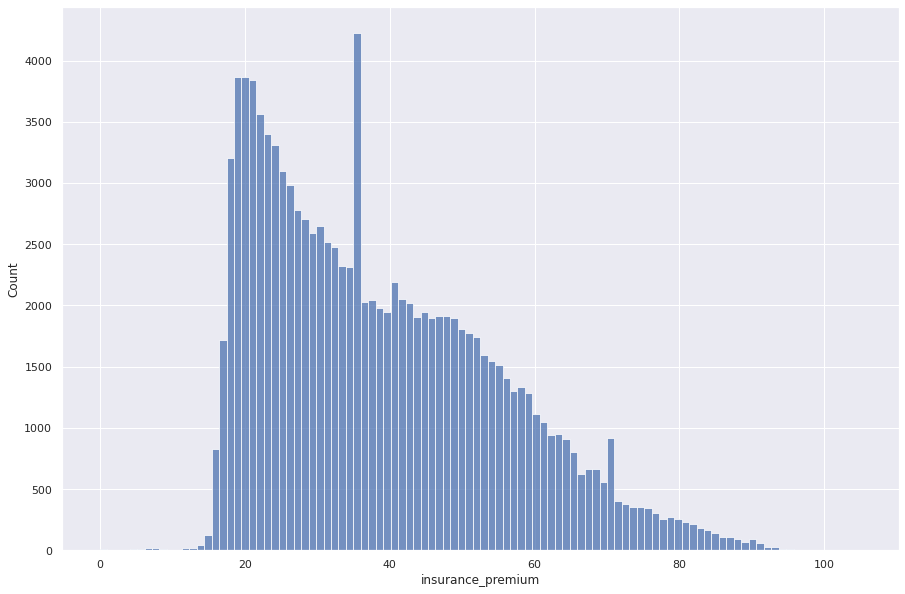

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


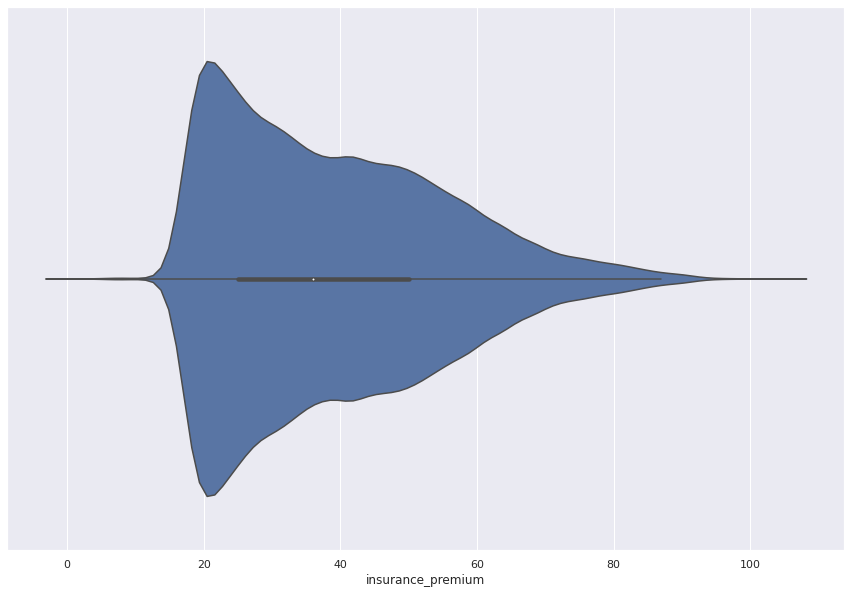

In [61]:
plots('insurance_premium')

missing значения можно интерпретировать как нулевые значения

In [62]:
df_for_model['insurance_premium'] = df_for_model['insurance_premium'].fillna(0)

In [63]:
values_and_missing('insurance_premium')

0.0      5134
19.0     3867
20.0     3865
21.0     3844
22.0     3563
         ... 
99.0        3
100.0       2
102.0       1
105.0       1
2.0         1
Name: insurance_premium, Length: 102, dtype: int64
missing_values:  0


In [64]:
df_for_model['insurance_premium'].quantile(0.975)

76.0

In [65]:
Q1 = df_for_model['insurance_premium'].quantile(0.25)
Q3 = df_for_model['insurance_premium'].quantile(0.75)
IQR = Q3 - Q1

# определение верхней и нижней границы
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [66]:
lower_bound, upper_bound

(-16.0, 88.0)

In [67]:
df_for_model = df_for_model.query('insurance_premium < 88')
df_for_model

,party_sobriety,insurance_premium,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_age,intersection,weather_1,location_type,collision_damage,primary_collision_factor,pcf_violation_category,type_of_collision,road_surface,motor_vehicle_involved_with,road_condition_1,lighting,season,time_of_day,at_fault
0,had not been drinking,48.0,None,0.0,sedan,3.0,0.0,clear,highway,small damage,vehicle code violation,unsafe lane change,broadside,dry,other motor vehicle,normal,dark with street lights,зима,ночь,0
1,had not been drinking,21.0,None,0.0,sedan,3.0,0.0,clear,highway,small damage,vehicle code violation,unsafe lane change,broadside,dry,other motor vehicle,normal,dark with street lights,зима,ночь,1
2,had not been drinking,56.0,None,0.0,sedan,3.0,0.0,clear,None,small damage,vehicle code violation,dui,sideswipe,dry,other motor vehicle,normal,dark with street lights,зима,ночь,0
3,"had been drinking, under influence",22.0,None,0.0,sedan,3.0,0.0,clear,None,small damage,vehicle code violation,dui,sideswipe,dry,other motor vehicle,normal,dark with street lights,зима,ночь,1
4,had not been drinking,60.0,None,0.0,sedan,4.0,0.0,clear,ramp,small damage,vehicle code violation,unsafe starting or backing,other,dry,other motor vehicle,normal,daylight,зима,утро,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118406,had not been drinking,23.0,None,0.0,sedan,3.0,0.0,clear,None,small damage,vehicle code violation,speeding,hit object,dry,fixed object,normal,daylight,лето,день,1
118407,had not been drinking,23.0,None,0.0,sedan,6.0,0.0,clear,highway,small damage,vehicle code violation,unsafe lane change,sideswipe,dry,other motor vehicle,normal,daylight,лето,день,1
118408,had not been drinking,41.0,None,0.0,sedan,6.0,0.0,clear,highway,small damage,vehicle code violation,unsafe lane change,sideswipe,dry,other motor vehicle,normal,daylight,лето,день,0
118409,had not been drinking,23.0,None,0.0,sedan,3.0,0.0,clear,highway,small damage,vehicle code violation,unsafe lane change,sideswipe,dry,other motor vehicle,normal,daylight,лето,день,1


### party_drug_physical

In [68]:
values_and_missing('party_drug_physical')

G                        6085
under drug influence     1309
not applicable            576
sleepy/fatigued           531
impairment - physical     177
Name: party_drug_physical, dtype: int64
missing_values:  109322


Здесь очень много пропущенных значений. "Неизвестно" как категория здесь G. Можно все миссин значения представить в виде G

In [69]:
df_for_model['party_drug_physical'] = df_for_model['party_drug_physical'].fillna('G')

In [70]:
values_and_missing('party_drug_physical')

G                        115407
under drug influence       1309
not applicable              576
sleepy/fatigued             531
impairment - physical       177
Name: party_drug_physical, dtype: int64
missing_values:  0


In [71]:
values_and_missing('party_drug_physical')

G                        115407
under drug influence       1309
not applicable              576
sleepy/fatigued             531
impairment - physical       177
Name: party_drug_physical, dtype: int64
missing_values:  0


In [72]:
df_for_model.columns

Index(['party_sobriety', 'insurance_premium', 'party_drug_physical',
       'cellphone_in_use', 'vehicle_type', 'vehicle_age', 'intersection',
       'weather_1', 'location_type', 'collision_damage',
       'primary_collision_factor', 'pcf_violation_category',
       'type_of_collision', 'road_surface', 'motor_vehicle_involved_with',
       'road_condition_1', 'lighting', 'season', 'time_of_day', 'at_fault'],
      dtype='object')

### cellphone_in_use

In [73]:
values_and_missing('cellphone_in_use')

0.0    104842
1.0      2289
Name: cellphone_in_use, dtype: int64
missing_values:  10869


11к пропущенных значений, заменим их нулями

In [74]:
df_for_model['cellphone_in_use'] = df_for_model['cellphone_in_use'].fillna(0)

In [75]:
values_and_missing('cellphone_in_use')

0.0    115711
1.0      2289
Name: cellphone_in_use, dtype: int64
missing_values:  0


### vehicle_type

In [76]:
values_and_missing('vehicle_type')

sedan        76577
coupe        35691
hatchback     3257
minivan       2418
other           57
Name: vehicle_type, dtype: int64
missing_values:  0


other слишком малочислена. Можно удалить вовсе

In [77]:
df_for_model= df_for_model.drop(df_for_model[df_for_model['vehicle_type'] == 'other'].index)


In [78]:
df_for_model

,party_sobriety,insurance_premium,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_age,intersection,weather_1,location_type,collision_damage,primary_collision_factor,pcf_violation_category,type_of_collision,road_surface,motor_vehicle_involved_with,road_condition_1,lighting,season,time_of_day,at_fault
0,had not been drinking,48.0,G,0.0,sedan,3.0,0.0,clear,highway,small damage,vehicle code violation,unsafe lane change,broadside,dry,other motor vehicle,normal,dark with street lights,зима,ночь,0
1,had not been drinking,21.0,G,0.0,sedan,3.0,0.0,clear,highway,small damage,vehicle code violation,unsafe lane change,broadside,dry,other motor vehicle,normal,dark with street lights,зима,ночь,1
2,had not been drinking,56.0,G,0.0,sedan,3.0,0.0,clear,None,small damage,vehicle code violation,dui,sideswipe,dry,other motor vehicle,normal,dark with street lights,зима,ночь,0
3,"had been drinking, under influence",22.0,G,0.0,sedan,3.0,0.0,clear,None,small damage,vehicle code violation,dui,sideswipe,dry,other motor vehicle,normal,dark with street lights,зима,ночь,1
4,had not been drinking,60.0,G,0.0,sedan,4.0,0.0,clear,ramp,small damage,vehicle code violation,unsafe starting or backing,other,dry,other motor vehicle,normal,daylight,зима,утро,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118406,had not been drinking,23.0,G,0.0,sedan,3.0,0.0,clear,None,small damage,vehicle code violation,speeding,hit object,dry,fixed object,normal,daylight,лето,день,1
118407,had not been drinking,23.0,G,0.0,sedan,6.0,0.0,clear,highway,small damage,vehicle code violation,unsafe lane change,sideswipe,dry,other motor vehicle,normal,daylight,лето,день,1
118408,had not been drinking,41.0,G,0.0,sedan,6.0,0.0,clear,highway,small damage,vehicle code violation,unsafe lane change,sideswipe,dry,other motor vehicle,normal,daylight,лето,день,0
118409,had not been drinking,23.0,G,0.0,sedan,3.0,0.0,clear,highway,small damage,vehicle code violation,unsafe lane change,sideswipe,dry,other motor vehicle,normal,daylight,лето,день,1


In [79]:
values_and_missing('vehicle_type')

sedan        76577
coupe        35691
hatchback     3257
minivan       2418
Name: vehicle_type, dtype: int64
missing_values:  0


### vehicle_age

In [80]:
values_and_missing('vehicle_age')

3.0      21581
4.0      14597
2.0      12792
5.0      11754
6.0       8494
7.0       8312
8.0       7650
0.0       6717
9.0       6080
1.0       5678
10.0      4286
11.0      3010
12.0      1877
13.0      1174
14.0       494
15.0        65
16.0        18
17.0         6
161.0        4
19.0         1
Name: vehicle_age, dtype: int64
missing_values:  3353


Старые оч машины я наверное удалю. А missing значения я представлю в виде среднего

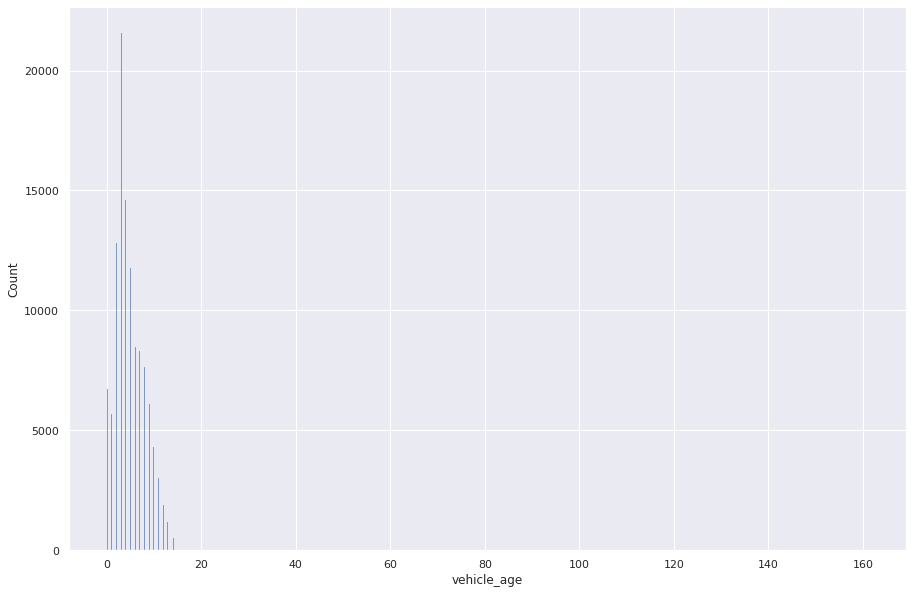

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


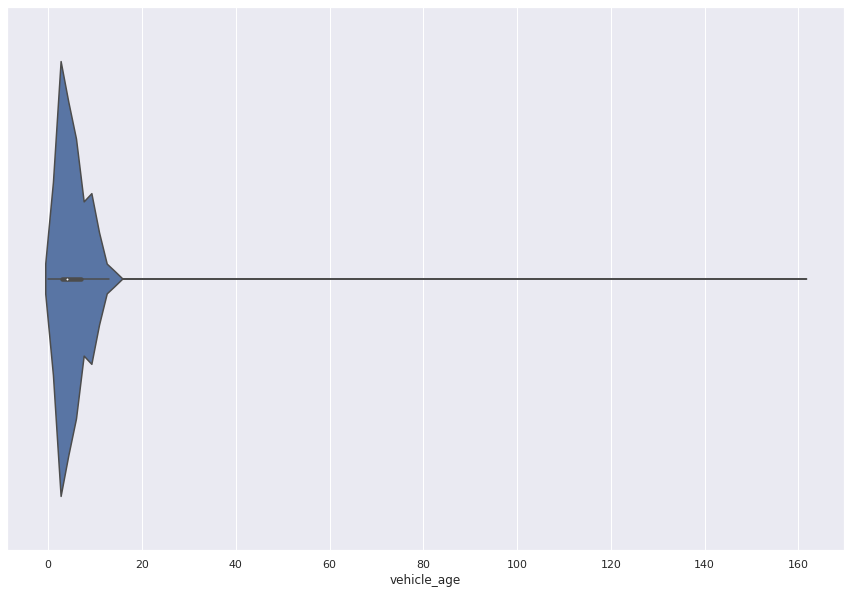

In [81]:
plots('vehicle_age')

In [82]:
mean_age = df_for_model['vehicle_age'].mean()

In [83]:
Q1 = df_for_model['vehicle_age'].quantile(0.25)
Q3 = df_for_model['vehicle_age'].quantile(0.75)
IQR = Q3 - Q1

# определение верхней и нижней границы
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [84]:
lower_bound,upper_bound 

(-3.0, 13.0)

In [85]:
df_for_model.loc[df_for_model['vehicle_age'] > 13, 'vehicle_age'] = 13

In [86]:
df_for_model['vehicle_age'] = df_for_model['vehicle_age'].fillna(5)

In [87]:
mean_age.round()

5.0

In [88]:
values_and_missing('vehicle_age')

3.0     21581
5.0     15107
4.0     14597
2.0     12792
6.0      8494
7.0      8312
8.0      7650
0.0      6717
9.0      6080
1.0      5678
10.0     4286
11.0     3010
12.0     1877
13.0     1762
Name: vehicle_age, dtype: int64
missing_values:  0


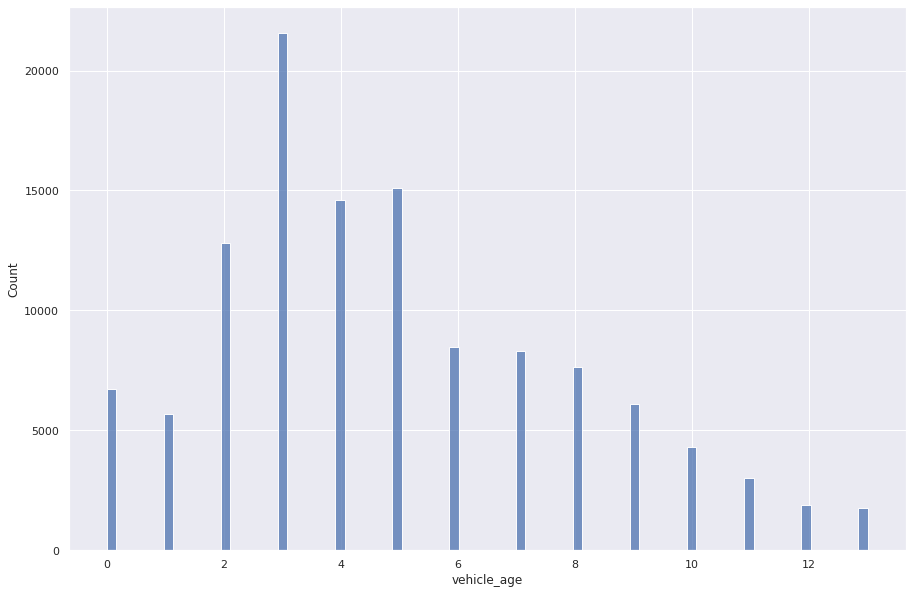

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


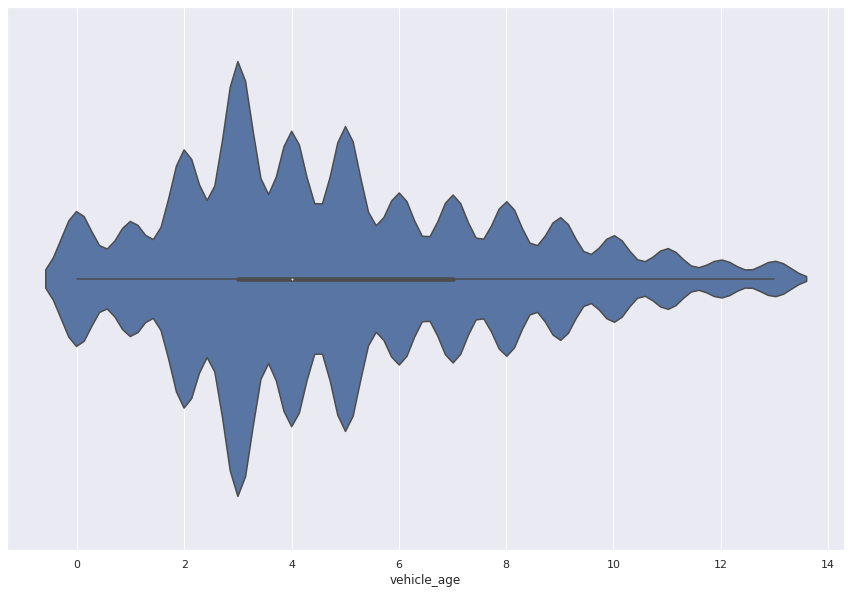

In [89]:
plots('vehicle_age')

Графики смотрятся уже иначе. Старые авто заменили, а миссин значения проставили средним округленным.

In [90]:
df_for_model.columns

Index(['party_sobriety', 'insurance_premium', 'party_drug_physical',
       'cellphone_in_use', 'vehicle_type', 'vehicle_age', 'intersection',
       'weather_1', 'location_type', 'collision_damage',
       'primary_collision_factor', 'pcf_violation_category',
       'type_of_collision', 'road_surface', 'motor_vehicle_involved_with',
       'road_condition_1', 'lighting', 'season', 'time_of_day', 'at_fault'],
      dtype='object')

### intersection

In [91]:
values_and_missing('intersection')

0.0    90058
1.0    27520
Name: intersection, dtype: int64
missing_values:  365


In [92]:
df_for_model['intersection'] = df_for_model['intersection'].fillna(0)

In [93]:
values_and_missing('intersection')

0.0    90423
1.0    27520
Name: intersection, dtype: int64
missing_values:  0


### weather_1

In [94]:
values_and_missing('weather_1')

clear      95646
cloudy     16970
raining     4202
fog          387
snowing      266
other         63
wind          23
Name: weather_1, dtype: int64
missing_values:  386


Как по мне,  можно скомпоновать мелкие категории, ведь они все условно плохие для вождения.

In [95]:
df_for_model['weather_1'] = df_for_model['weather_1'].replace(['fog', 'snowing', 'other', 'wind'], 'other')


In [96]:
df_for_model['weather_1'] = df_for_model['weather_1'].fillna('other')

In [97]:
values_and_missing('weather_1')

clear      95646
cloudy     16970
raining     4202
other       1125
Name: weather_1, dtype: int64
missing_values:  0


### location_type

In [98]:
values_and_missing('location_type')

highway         45932
ramp             6243
intersection     2844
Name: location_type, dtype: int64
missing_values:  62924


Миссин значений оч много, их большая часть. <br>
Добавим новую категорию 'unknown'  

In [99]:
df_for_model['location_type'] = df_for_model['location_type'].fillna('unknown')

In [100]:
values_and_missing('location_type')

unknown         62924
highway         45932
ramp             6243
intersection     2844
Name: location_type, dtype: int64
missing_values:  0


### collision_damage

In [101]:
values_and_missing('collision_damage')

small damage     62851
middle damage    41556
severe damage     7576
fatal             5960
Name: collision_damage, dtype: int64
missing_values:  0


Как по мне, этот столбец выглядит хорошо. Я его трогать не буду. 

### primary_collision_factor

In [102]:
values_and_missing('primary_collision_factor')

vehicle code violation    113745
unknown                     1811
other than driver           1691
other improper driving       431
fell asleep                    3
Name: primary_collision_factor, dtype: int64
missing_values:  262


Этот столбец очень сильно коррелировал с другим столбцом pcf_violation_category. <br>
Поэтому, я оставлю лишь один, который лучше всего информирует.

Сравним эти столбцы

### pcf_violation_category

In [103]:
values_and_missing('pcf_violation_category')

speeding                             41619
automobile right of way              15333
improper turning                     13109
dui                                  10460
unsafe lane change                   10295
traffic signals and signs             7698
wrong side of road                    3257
unsafe starting or backing            2765
following too closely                 2402
unknown                               1982
pedestrian violation                  1693
other than driver (or pedestrian)     1691
other hazardous violation             1178
improper passing                      1023
pedestrian right of way                973
other improper driving                 431
other equipment                        151
impeding traffic                        79
hazardous parking                       50
brakes                                  20
lights                                  16
fell asleep                              3
Name: pcf_violation_category, dtype: int64
missing_val

Здесь есть много малочисленных категорий. Однако этот столбец очень хорошо информирует о ситуации (по-моему мнению, лучше чем prim collision)

In [104]:
df_for_model['pcf_violation_category'] = df_for_model['pcf_violation_category'].replace(
    ['fell asleep', 'lights', 'brakes', 'hazardous parking', 'impeding traffic',
    'other equipment'], 'other improper driving')


In [105]:
df_for_model['pcf_violation_category'] = df_for_model['pcf_violation_category'].fillna('unknown')

In [106]:
values_and_missing('pcf_violation_category')

speeding                             41619
automobile right of way              15333
improper turning                     13109
dui                                  10460
unsafe lane change                   10295
traffic signals and signs             7698
unknown                               3697
wrong side of road                    3257
unsafe starting or backing            2765
following too closely                 2402
pedestrian violation                  1693
other than driver (or pedestrian)     1691
other hazardous violation             1178
improper passing                      1023
pedestrian right of way                973
other improper driving                 750
Name: pcf_violation_category, dtype: int64
missing_values:  0


In [107]:
df_for_model = df_for_model.drop('primary_collision_factor', axis=1)

In [108]:
df_for_model

,party_sobriety,insurance_premium,party_drug_physical,cellphone_in_use,vehicle_type,vehicle_age,intersection,weather_1,location_type,collision_damage,pcf_violation_category,type_of_collision,road_surface,motor_vehicle_involved_with,road_condition_1,lighting,season,time_of_day,at_fault
0,had not been drinking,48.0,G,0.0,sedan,3.0,0.0,clear,highway,small damage,unsafe lane change,broadside,dry,other motor vehicle,normal,dark with street lights,зима,ночь,0
1,had not been drinking,21.0,G,0.0,sedan,3.0,0.0,clear,highway,small damage,unsafe lane change,broadside,dry,other motor vehicle,normal,dark with street lights,зима,ночь,1
2,had not been drinking,56.0,G,0.0,sedan,3.0,0.0,clear,unknown,small damage,dui,sideswipe,dry,other motor vehicle,normal,dark with street lights,зима,ночь,0
3,"had been drinking, under influence",22.0,G,0.0,sedan,3.0,0.0,clear,unknown,small damage,dui,sideswipe,dry,other motor vehicle,normal,dark with street lights,зима,ночь,1
4,had not been drinking,60.0,G,0.0,sedan,4.0,0.0,clear,ramp,small damage,unsafe starting or backing,other,dry,other motor vehicle,normal,daylight,зима,утро,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118406,had not been drinking,23.0,G,0.0,sedan,3.0,0.0,clear,unknown,small damage,speeding,hit object,dry,fixed object,normal,daylight,лето,день,1
118407,had not been drinking,23.0,G,0.0,sedan,6.0,0.0,clear,highway,small damage,unsafe lane change,sideswipe,dry,other motor vehicle,normal,daylight,лето,день,1
118408,had not been drinking,41.0,G,0.0,sedan,6.0,0.0,clear,highway,small damage,unsafe lane change,sideswipe,dry,other motor vehicle,normal,daylight,лето,день,0
118409,had not been drinking,23.0,G,0.0,sedan,3.0,0.0,clear,highway,small damage,unsafe lane change,sideswipe,dry,other motor vehicle,normal,daylight,лето,день,1


In [109]:
df_for_model.columns

Index(['party_sobriety', 'insurance_premium', 'party_drug_physical',
       'cellphone_in_use', 'vehicle_type', 'vehicle_age', 'intersection',
       'weather_1', 'location_type', 'collision_damage',
       'pcf_violation_category', 'type_of_collision', 'road_surface',
       'motor_vehicle_involved_with', 'road_condition_1', 'lighting', 'season',
       'time_of_day', 'at_fault'],
      dtype='object')

### road_surface

In [110]:
values_and_missing('road_surface')

dry         106471
wet          10076
snowy          563
slippery        72
Name: road_surface, dtype: int64
missing_values:  761


In [111]:
df_for_model['road_surface'] = df_for_model['road_surface'].fillna('unknown')

In [112]:
df_for_model['road_surface'] = df_for_model['road_surface'].replace(
    ['slippery', 'snowy'], 'dangerous')

In [113]:
values_and_missing('road_surface')

dry          106471
wet           10076
unknown         761
dangerous       635
Name: road_surface, dtype: int64
missing_values:  0


Объединил опасные категории в одну. А мисс значения определил в неизвестные.

### motor_vehicle_involved_with

In [114]:
values_and_missing('motor_vehicle_involved_with')

other motor vehicle               94000
fixed object                       9387
other object                       5357
non-collision                      2857
bicycle                            2769
parked motor vehicle               2055
motor vehicle on other roadway      930
animal                              234
train                                26
Name: motor_vehicle_involved_with, dtype: int64
missing_values:  328


Объединю other c animal и train

In [115]:
df_for_model['motor_vehicle_involved_with'] = df_for_model['motor_vehicle_involved_with'].replace(
    ['train','animal'], 'other object')

In [116]:
df_for_model['motor_vehicle_involved_with'] = df_for_model['motor_vehicle_involved_with'].fillna('unknown')

In [117]:
values_and_missing('motor_vehicle_involved_with')

other motor vehicle               94000
fixed object                       9387
other object                       5617
non-collision                      2857
bicycle                            2769
parked motor vehicle               2055
motor vehicle on other roadway      930
unknown                             328
Name: motor_vehicle_involved_with, dtype: int64
missing_values:  0


### road_condition_1

In [118]:
values_and_missing('road_condition_1')

normal            113350
construction        2295
holes                473
obstruction          458
other                426
loose material       187
reduced width        132
flooded               56
Name: road_condition_1, dtype: int64
missing_values:  566


Пусть будет три категории. Опасный, нормальный, неизвестный

In [119]:
df_for_model['road_condition_1'] = df_for_model['road_condition_1'].replace(
    ['flooded','reduced width','loose material','other','obstruction','holes', 'construction'], 'dangerous')

In [120]:
df_for_model['road_condition_1'] = df_for_model['road_condition_1'].fillna('unknown')

In [121]:
values_and_missing('road_condition_1')

normal       113350
dangerous      4027
unknown         566
Name: road_condition_1, dtype: int64
missing_values:  0


### lighting

In [122]:
values_and_missing('lighting')

daylight                                   82565
dark with street lights                    22010
dark with no street lights                  9055
dusk or dawn                                3697
dark with street lights not functioning      288
Name: lighting, dtype: int64
missing_values:  328


In [123]:
df_for_model['lighting'] = df_for_model['lighting'].fillna('unknown')

In [124]:
df_for_model['lighting']  = df_for_model['lighting'].replace(['ark with street lights not functioning', 
                                                             'dusk or dawn'], 'dangerous')

In [125]:
values_and_missing('lighting')

daylight                                   82565
dark with street lights                    22010
dark with no street lights                  9055
dangerous                                   3697
unknown                                      328
dark with street lights not functioning      288
Name: lighting, dtype: int64
missing_values:  0


### season

In [126]:
values_and_missing('season')

весна    66865
зима     45019
лето      4212
осень     1847
Name: season, dtype: int64
missing_values:  0


### time_of_day

In [127]:
values_and_missing('time_of_day')

день     53104
утро     30877
вечер    22028
ночь     11934
Name: time_of_day, dtype: int64
missing_values:  0


### at_fault

In [128]:
values_and_missing('at_fault')

0    62656
1    55287
Name: at_fault, dtype: int64
missing_values:  0


Особого дисбаланса нет

### type_of_collision

In [129]:
values_and_missing('type_of_collision')

rear end      45373
broadside     26220
sideswipe     19955
hit object    10123
head-on        6895
other          6055
overturned     2686
Name: type_of_collision, dtype: int64
missing_values:  636


In [130]:
df_for_model['type_of_collision'] = df_for_model['type_of_collision'].fillna('other')

In [131]:
values_and_missing('type_of_collision')

rear end      45373
broadside     26220
sideswipe     19955
hit object    10123
head-on        6895
other          6691
overturned     2686
Name: type_of_collision, dtype: int64
missing_values:  0


In [132]:
df_for_model.dtypes

party_sobriety                  object
insurance_premium              float64
party_drug_physical             object
cellphone_in_use               float64
vehicle_type                    object
vehicle_age                    float64
intersection                   float64
weather_1                       object
location_type                   object
collision_damage                object
pcf_violation_category          object
type_of_collision               object
road_surface                    object
motor_vehicle_involved_with     object
road_condition_1                object
lighting                        object
season                          object
time_of_day                     object
at_fault                         int64
dtype: object

In [133]:
df_for_model.columns

Index(['party_sobriety', 'insurance_premium', 'party_drug_physical',
       'cellphone_in_use', 'vehicle_type', 'vehicle_age', 'intersection',
       'weather_1', 'location_type', 'collision_damage',
       'pcf_violation_category', 'type_of_collision', 'road_surface',
       'motor_vehicle_involved_with', 'road_condition_1', 'lighting', 'season',
       'time_of_day', 'at_fault'],
      dtype='object')

In [134]:
nan_in_columns = df_for_model.isnull().any()

print(nan_in_columns)

party_sobriety                 False
insurance_premium              False
party_drug_physical            False
cellphone_in_use               False
vehicle_type                   False
vehicle_age                    False
intersection                   False
weather_1                      False
location_type                  False
collision_damage               False
pcf_violation_category         False
type_of_collision              False
road_surface                   False
motor_vehicle_involved_with    False
road_condition_1               False
lighting                       False
season                         False
time_of_day                    False
at_fault                       False
dtype: bool


In [135]:
nan_count_in_columns = df_for_model.isnull().sum()
nan_count_in_columns

party_sobriety                 0
insurance_premium              0
party_drug_physical            0
cellphone_in_use               0
vehicle_type                   0
vehicle_age                    0
intersection                   0
weather_1                      0
location_type                  0
collision_damage               0
pcf_violation_category         0
type_of_collision              0
road_surface                   0
motor_vehicle_involved_with    0
road_condition_1               0
lighting                       0
season                         0
time_of_day                    0
at_fault                       0
dtype: int64

In [136]:
X_train, X_test, y_train, y_test = train_test_split(df_for_model.drop('at_fault', axis = 1),
                                                    df_for_model['at_fault'],
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=SEED)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(82560, 18) (35383, 18) (82560,) (35383,)


In [137]:
cols = X_train.columns

Выборки готовы. 

In [138]:
X_train.dtypes

party_sobriety                  object
insurance_premium              float64
party_drug_physical             object
cellphone_in_use               float64
vehicle_type                    object
vehicle_age                    float64
intersection                   float64
weather_1                       object
location_type                   object
collision_damage                object
pcf_violation_category          object
type_of_collision               object
road_surface                    object
motor_vehicle_involved_with     object
road_condition_1                object
lighting                        object
season                          object
time_of_day                     object
dtype: object

In [139]:
cat = df_for_model.columns.drop(['vehicle_age', 'insurance_premium', 'intersection', 'cellphone_in_use', 'at_fault'])

In [140]:
num = ['vehicle_age', 'insurance_premium', 'intersection', 'cellphone_in_use']

In [141]:
cat, num

(Index(['party_sobriety', 'party_drug_physical', 'vehicle_type', 'weather_1',
        'location_type', 'collision_damage', 'pcf_violation_category',
        'type_of_collision', 'road_surface', 'motor_vehicle_involved_with',
        'road_condition_1', 'lighting', 'season', 'time_of_day'],
       dtype='object'),
 ['vehicle_age', 'insurance_premium', 'intersection', 'cellphone_in_use'])

In [142]:
column_transformer = make_column_transformer(
                         ( StandardScaler(), num),
                            ( OneHotEncoder(handle_unknown='ignore'), cat),
                                remainder="passthrough")

In [143]:
column_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['vehicle_age', 'insurance_premium',
                                  'intersection', 'cellphone_in_use']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 Index(['party_sobriety', 'party_drug_physical', 'vehicle_type', 'weather_1',
       'location_type', 'collision_damage', 'pcf_violation_category',
       'type_of_collision', 'road_surface', 'motor_vehicle_involved_with',
       'road_condition_1', 'lighting', 'season', 'time_of_day'],
      dtype='object'))])

Я решил выбрать метрику F1, дабы получить баланс между точностью и полнотой. 

Сперва я начну с леса. Далее попробуем Catboost и скорее всего не станет подбирать к нему гиперпараметры. <br>
дефолтный CatBoost неплохо подбирает и сам. 

### Random forest

In [144]:
fbeta= make_scorer(fbeta_score, beta=2)

In [158]:
model = RandomForestClassifier( random_state = SEED) 

In [159]:
params ={'randomforestclassifier__max_depth':[3,5,10, None],
              'randomforestclassifier__n_estimators':[10,100,200],
              'randomforestclassifier__max_features':[1,3,5,7],
              'randomforestclassifier__min_samples_leaf':[1,2,3]
           }

In [160]:
pipeline = make_pipeline(column_transformer, model)
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['vehicle_age',
                                                   'insurance_premium',
                                                   'intersection',
                                                   'cellphone_in_use']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['party_sobriety', 'party_drug_physical', 'vehicle_type', 'weather_1',
       'location_type', 'collision_damage', 'pcf_violation_category',
       'type_of_collision', 'road_surface', 'motor_vehicle_involved_with',
       'road_condition_1', 'lighting', 'season', 'time_of_d

In [161]:
grid = RandomizedSearchCV(pipeline, params, n_jobs=-1, cv=3, scoring=fbeta) 
model_grid = grid.fit(X_train,y_train)

In [163]:
print(model_grid.best_params_)
score_forest = model_grid.best_score_
score_forest

{'randomforestclassifier__n_estimators': 10, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_features': 1, 'randomforestclassifier__max_depth': None}


0.47533411083550653

## decision tree

In [151]:
model_dtc = DecisionTreeClassifier(random_state=SEED)

In [152]:
params ={'decisiontreeclassifier__max_depth' : [5, 6, 7, 8, 9],
              'decisiontreeclassifier__criterion':['gini', 'entropy'],
              'decisiontreeclassifier__max_features': ['auto', 'sqrt', 'log2'],
              'decisiontreeclassifier__min_samples_split':[2,4,5,10,15]
           }

In [153]:
pipeline_dtc = make_pipeline(column_transformer, model_dtc)


In [154]:
grid_dtc = RandomizedSearchCV(pipeline_dtc, params, n_jobs=-1, cv=3, scoring=fbeta) 
model_grid_dtc = grid_dtc.fit(X_train,y_train)

In [155]:
model_grid_dtc.best_params_

{'decisiontreeclassifier__min_samples_split': 10,
 'decisiontreeclassifier__max_features': 'log2',
 'decisiontreeclassifier__max_depth': 9,
 'decisiontreeclassifier__criterion': 'gini'}

In [156]:
score_tree = model_grid_dtc.best_score_

In [157]:
score_tree

0.515895695418068

## cat boost

In [164]:
import catboost
print(catboost.__version__)

1.0.3


In [165]:
model = CatBoostClassifier( random_seed= SEED)

In [166]:
def objective(trial):
    model = CatBoostClassifier(
      iterations=trial.suggest_int("iterations", 100, 1000),
      learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
      depth=trial.suggest_int("depth", 4, 10),
      l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
      bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
      random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
      bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
      od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
      od_wait=trial.suggest_int("od_wait", 10, 50),
      verbose=False
  )
  
  # Определение pipeline
    pipeline = make_pipeline(column_transformer, model)
  
  # Обучение модели
    pipeline.fit(X_train, y_train)  
  # Предсказание и оценка модели
    preds = pipeline.predict(X_test)
    return fbeta_score(y_test, preds, beta=2)

# Создание исследования
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Вывод лучших гиперпараметров
print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

[I 2023-11-25 19:51:50,691] A new study created in memory with name: no-name-77dfd831-3fc4-4e8d-a508-412eb5aefed4
[I 2023-11-25 19:52:01,181] Trial 0 finished with value: 0.5659565172697368 and parameters: {'iterations': 313, 'learning_rate': 0.006013926122666474, 'depth': 9, 'l2_leaf_reg': 1.6070629164454417e-07, 'bootstrap_type': 'Bayesian', 'random_strength': 0.00037189105175301865, 'bagging_temperature': 4.356930307511924, 'od_type': 'Iter', 'od_wait': 50}. Best is trial 0 with value: 0.5659565172697368.
[I 2023-11-25 19:52:08,044] Trial 1 finished with value: 0.4977527203911055 and parameters: {'iterations': 305, 'learning_rate': 0.00236757501784031, 'depth': 4, 'l2_leaf_reg': 74.99136185167926, 'bootstrap_type': 'Bayesian', 'random_strength': 9.165487166995709, 'bagging_temperature': 5.376384140634528, 'od_type': 'IncToDec', 'od_wait': 38}. Best is trial 0 with value: 0.5659565172697368.
[I 2023-11-25 19:52:19,951] Trial 2 finished with value: 0.5776626088728162 and parameters: {

Best trial:
 Value:  0.6346952693905388
 Params: 
 iterations: 930
 learning_rate: 0.09108068442174753
 depth: 10
 l2_leaf_reg: 0.0010847620180042437
 bootstrap_type: Bayesian
 random_strength: 1.2402931374193057e-06
 bagging_temperature: 0.17793676868208239
 od_type: IncToDec
 od_wait: 25


In [171]:
study.best_trial.params

{'iterations': 930,
 'learning_rate': 0.09108068442174753,
 'depth': 10,
 'l2_leaf_reg': 0.0010847620180042437,
 'bootstrap_type': 'Bayesian',
 'random_strength': 1.2402931374193057e-06,
 'bagging_temperature': 0.17793676868208239,
 'od_type': 'IncToDec',
 'od_wait': 25}

In [172]:
best_params = study.best_trial.params

# Создание модели CatBoost с лучшими гиперпараметрами
model = CatBoostClassifier(
   iterations=best_params['iterations'],
   learning_rate=best_params['learning_rate'],
   depth=best_params['depth'],
   l2_leaf_reg=best_params['l2_leaf_reg'],
   bootstrap_type=best_params['bootstrap_type'],
   random_strength=best_params['random_strength'],
   bagging_temperature=best_params['bagging_temperature'],
   od_type=best_params['od_type'],
   od_wait=best_params['od_wait'],
   verbose=False
)

pipeline = make_pipeline(column_transformer, model)
  
pipeline.fit(X_train, y_train)  

preds = pipeline.predict(X_test)

In [177]:
score_cat = fbeta_score(y_test, preds, beta=2)

In [174]:
importances = pipeline['catboostclassifier'].get_feature_importance()

In [178]:
data = [score_tree, score_forest, score_cat ]

In [179]:
scores = pd.DataFrame(data, columns= ['score'],
                      index= ['tree', 'random_forest', 'cat_boost'])
scores

,score
tree,0.515896
random_forest,0.475334
cat_boost,0.634695


Мне очень нравится библиотека CatBoost, так что буду работать с ней, в теории знаю, что catboost выдает не хуже score, чем forest, однако у леса очень долгое обучение, что мне не нравится. 

## Проведите анализ важности факторов ДТП

Далее выведу feature_importance

In [180]:
feature_names = X_train.columns.tolist()
feature_importances = dict(zip(feature_names, importances))

In [181]:
sorted_feature_importances = sorted(feature_importances.items(),
                                    key=lambda x: x[1], reverse=True)
df = pd.DataFrame(sorted_feature_importances,
                  columns=['Feature', 'Importance'])

In [182]:
df

,Feature,Importance
0,insurance_premium,18.915200
1,party_sobriety,8.279004
2,party_drug_physical,2.421844
3,weather_1,1.778936
4,lighting,1.213941
5,intersection,1.106922
6,location_type,0.689096
7,cellphone_in_use,0.491332
8,pcf_violation_category,0.458355
9,time_of_day,0.362993


Преобладает в списке важности фичей - insurance_premium	, party_sobriety, party_drug_physical и weather_1. <br>

Для фичи time_of_day я провел более детальный осмотр

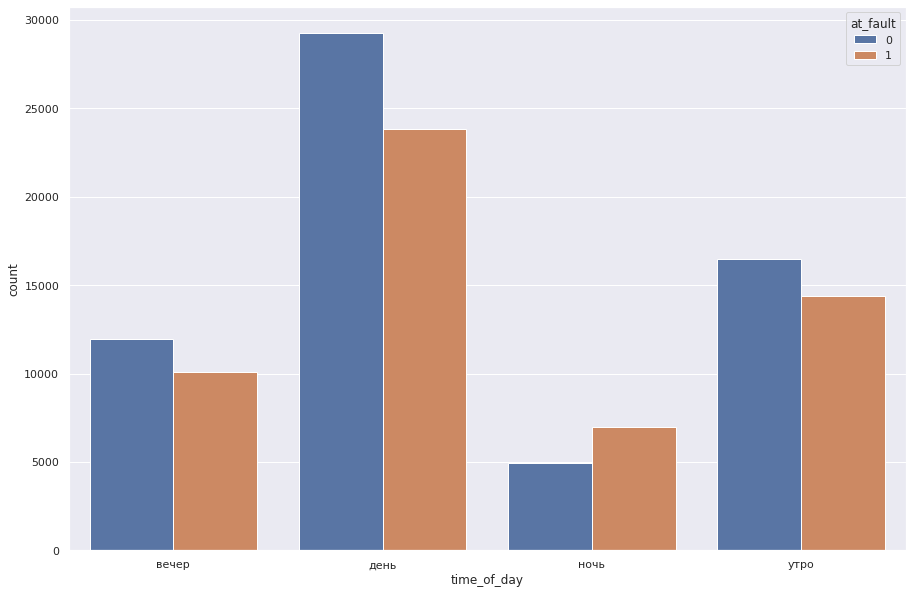

In [183]:
values = df_for_model.groupby('time_of_day')['at_fault'].value_counts().unstack()

#Создаем отдельный DataFrame для каждого значения в 'at_fault'
df_zero = values[0].reset_index()
df_zero.columns = ['time_of_day', 'count']
df_zero['at_fault'] = 0

df_one = values[1].reset_index()
df_one.columns = ['time_of_day', 'count']
df_one['at_fault'] = 1

df_combined = pd.concat([df_zero, df_one])

sns.barplot(data=df_combined, x='time_of_day', y='count', hue='at_fault')
plt.show()

Выявили, что для каждого времени дня at_fault = 0 меньше, at_fault=1, однако ночью ситуация изменяется. <br>
Возможно, нужно тщательнее следить за осветительными приборами на машинах компании. <br>
Или же ограничивать скорости специально для ночного времени. 

In [185]:
matrix = confusion_matrix(y_test, pipeline.predict(X_test))

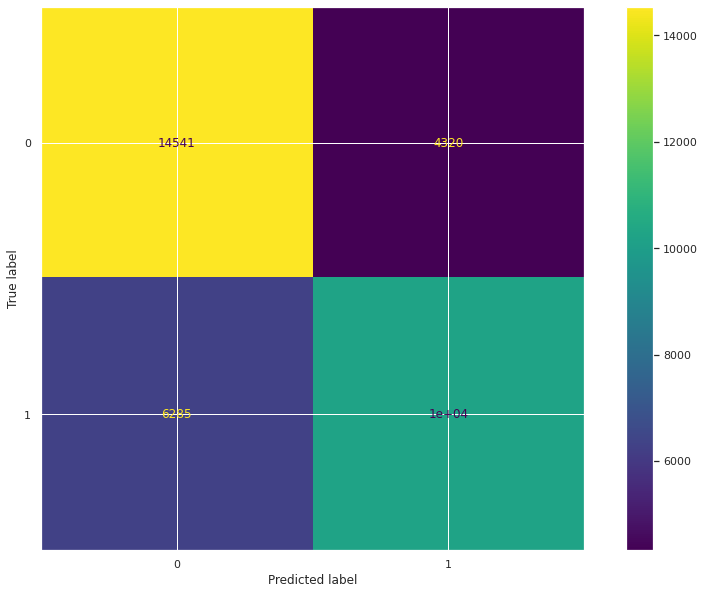

In [186]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix )
disp.plot()
plt.show()

Так выглядит матрица ошибок

Также построим  кривую тoчнocти-пoлнoты

In [207]:
def plot_pr_curve(y_test, model_probs):
    no_skill = len(y_test[y_test==1]) / len(y_test)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--')
    precision, recall, _ = precision_recall_curve(y_test, model_probs)
    pyplot.plot(recall, precision, marker='.')
 # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
 # show the plot
    pyplot.show()

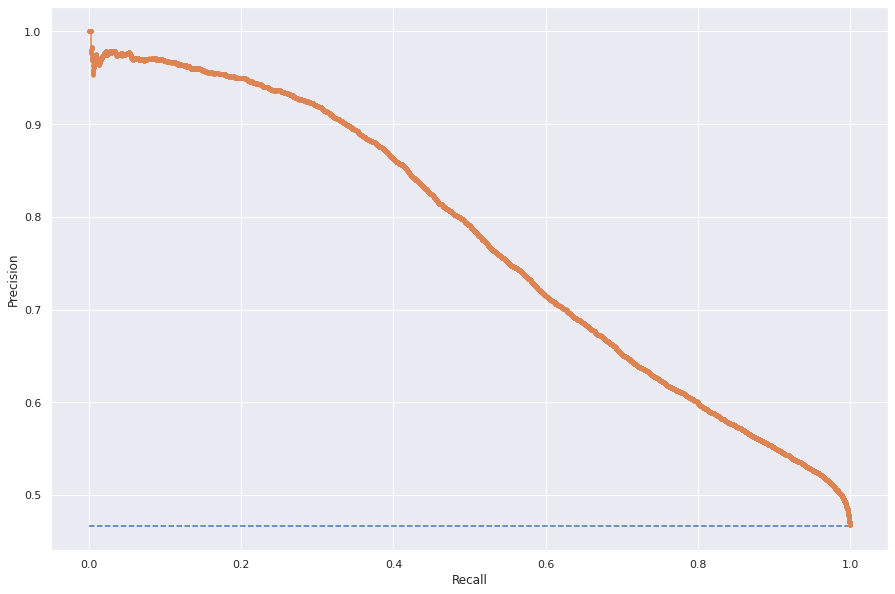

In [208]:
plot_pr_curve(y_test, pipeline.predict_proba(X_test)[:, 1])

## Выводы

Каков итог этого проекта? <br>
Наш заказчик просил нас создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. <br>
Однако, наш заказчик не предоставил нам данные, по которым можно было бы эту задачу выполнить. <br>
У нас были лишь названия городов, дистанция от главной дороги и направление движения. Это не координаты<br>
Также, в нашем датасете был столбец, который определяет был ли участник виновником аварии или нет. <br>
На основе этих данных мы можем предсказывать по факту аварии был ли этот человек виновником аварии. <br>
Но задачу, которую спустил нам заказчик с этими данными не выполнить. <br>
В рамках этого проекта мне понравилась модель CatBoost, я не замерял специально скорость обучения, однако я знаю определенно из опыта, что она быстрее древесных моделей. <br>
Также эта библиотека хороша тем, что работает адекватно из под коробки (дефолт настройки). 

Конечно же, мы попытались в рамках этого проекта изучить данные и сделать некоторые замечания и рекомендации, которые могут быть полезны каршеринговой компании. <br>

Продолжать улучшать эту модель не имеет смысла, ведь мы не можем удовлетворить требования заказчика. <br>

In [209]:
scores

,score
tree,0.515896
random_forest,0.475334
cat_boost,0.634695


По итогу, catboost оказался в данном случае лучшей моделью. Попробовал немного поиграться с optuna, показалась куда более сильным и интересным инструментом для перебора гиперпараметров. 